## Feature Engineering to Identify Important Variables
* Sangwon Baek
* May 6th, 2023

In [1]:
import pandas as pd
import numpy as np
import re
import random as rn
import statistics 
import os
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, norm, mannwhitneyu, chi2_contingency, fisher_exact, ttest_ind, zscore

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, ParameterGrid, StratifiedKFold, KFold
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from sklearn import metrics
from statsmodels.stats import contingency_tables
import statsmodels.api as sm

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import save_model
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from joblib import dump, load

from matplotlib.ticker import FuncFormatter


In [2]:
#Read csv file using pandas
df2 = pd.read_csv('../Data/Preprocessed/CRF_Initial.csv', low_memory=False)
df2 = df2.drop(columns='Unnamed: 0')

na_cols = ['UD_HT','UD_DM','UD_CVD','UD_cancer','UD_other','SMT_fever','SMT_cough','SMT_sputum','SMT_dyspnea',
          'SMT_myalgia', 'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'steroid']
df2[na_cols] = df2[na_cols].fillna(value=0)

#Remove D-Dimer from the dataframe
ColumnNames = ['No', 'ID', 'age', 'sex', 'dx_date', 'hospitalized_date', 'UD_HT', 'UD_DM', 'UD_CVD', 'UD_cancer',
              'UD_other', 'SMT_fever', 'SMT_cough', 'SMT_sputum', 'SMT_dyspnea', 'SMT_myalgia',
              'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'TX_0', 'TX_1', 'TX_2', 'TX_3', 'TX_4', 
               'Smoking_0', 'Smoking_1', 'Smoking_2', 'Smoking_3', 'BT', 'SBP', 
               'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH', 
               'DD', 'PCR', 'steroid', 'Mild','Moderate','Severe']
df2 = df2[ColumnNames].drop(columns = 'DD')
# Replace 'UD_' and 'SMT_' in the column names
new_column_names = {col: col.replace('UD_', '').replace('SMT_', '') for col in df2.columns}
# Rename the columns in the dataframe
df2 = df2.rename(columns=new_column_names)

#Separate DF into validation and developmentsets
DevelopmentSet = df2.loc[~df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
ValidationSet = df2.loc[df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]

### Data Conversion / Normalization / Train Test Split

In [3]:
def data_preprocessor(train_dataset, test_dataset, columnList, outcome):
    #Create train and test set
    X_train = train_dataset[columnList].values
    X_test = test_dataset[columnList].values
    Y_train = train_dataset[outcome].values.ravel()
    Y_test = test_dataset[outcome].values.ravel()
    
    #Apply StandardScaler Normalization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    return X_train, X_test, Y_train, Y_test

In [4]:
def Compute_CI(values):
    sample_mean = np.mean(values)
    # ddof=1 to compute sample standard deviation
    sample_std = np.std(values, ddof=1) 
    
    # for a 95% confidence interval
    z_value = norm.ppf(0.975)  
    ci_lower = sample_mean - z_value * (sample_std / np.sqrt(len(values)))
    ci_upper = sample_mean + z_value * (sample_std / np.sqrt(len(values)))
    return [ci_lower, ci_upper]

In [5]:
def Result_Table_Builder(modelName, ValidationType, num, costWeight):
    # Stack the results of ML and DL
    total_results = np.vstack(list(globals()[f"{modelName}_{ValidationType}_Results_{i}_{costWeight}"] for i in range(num)))
    
    #Create header column list
    if ValidationType == 'IV':
        header_list = ['ROC-AUC', 'PR-AUC']
    else:
        header_list = ['ROC-AUC']
        
    #Create index list
    index_list = [f'Variables #{i}' for i in range(num)]
    index_list[0] = 'ALL_Variables'
    
    #Create result table dataframe
    result_table = pd.DataFrame(data=total_results, columns=header_list, index=index_list)
    
    #Save the result table as CSV file
    # result_table.to_csv(f'../Result/{modelName}_{ValidationType}_{costWeight}_ResultTable.csv')
    
    return result_table

In [6]:
#List of Columns 
outcome = ['Severe']
#ALL Variables
Variables_0 = ['age', 'sex', 'HT', 'DM', 'CVD', 'cancer', 'other',
               'fever', 'cough', 'sputum', 'dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI', 
               'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']

#Select the variables that commonly appear among 6 selection techniques based on selection probability.
#Available Selection Probabilities exceeding 50%  
#{1}_{2}_{3}_V{4} : 1=Selection Probability, 2=Top cutoff, 3=Variable Numbers, 4=Version when same (default: 1)

#5
Variables_1 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR']
Variables_2 = ['CRP', 'LDH', 'ALC', 'ANC', 'dyspnea']

#6
Variables_3 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea']
Variables_4 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'WBC']
Variables_5 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'PLT']

#7 
Variables_6 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC']
Variables_7 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'PLT']
Variables_8 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'SPO2']

#8
Variables_9 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age']
Variables_10 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2']
Variables_11 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'DBP']

#9
Variables_12 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2']
Variables_13 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP']
Variables_14 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PR']
Variables_15 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'BT']

#10
Variables_16 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']
Variables_17 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PR']
Variables_18 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT']
Variables_19 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP']
Variables_20 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM']
Variables_21 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT']
Variables_22 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']

#11
Variables_23 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PR']
Variables_24 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'BT']
Variables_25 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP']
Variables_26 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'DM']
Variables_27 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT']
Variables_28 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'BT']
Variables_29 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'SBP']
Variables_30 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'DM']
Variables_31 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'PLT']
Variables_32 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DBP']
Variables_33 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'PR']
Variables_34 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SBP']
Variables_35 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DM']
Variables_36 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SPO2']
Variables_37 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'PR']
Variables_38 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'BT']
Variables_39 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP']
Variables_40 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DM']
Variables_41 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DBP']
Variables_42 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PR']
Variables_43 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'DM']
Variables_44 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PLT']
Variables_45 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'PR']
Variables_46 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'DM']
Variables_47 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'SBP']
Variables_48 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM', 'PR']
Variables_49 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'PR']
Variables_50 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'DM']

#12
Variables_51 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'BT']
Variables_52 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'SBP']
Variables_53 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'DM']
Variables_54 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'PR']
Variables_55 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'BT']
Variables_56 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'DM']
Variables_57 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'PR']
Variables_58 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'BT']
Variables_59 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'PLT']

#13
Variables_60 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP','DM', 'BT']

Num_Variables = 60

In [7]:
#Preprocess dataset based on columnList
for i in range (Num_Variables):
    exec(f"X{i}_train, X{i}_test, Y{i}_train, Y{i}_test = data_preprocessor(DevelopmentSet, ValidationSet, Variables_{i}, outcome)")

### DNN Model Training Through 5-fold Stratified Cross Validation and Internal Validation

In [8]:
#Hyperparameters and spaces for putting results
def Model_Train_DNN(X, Y, class_weights=None):
    #Define empty outer lists to store result values
    auc_outer_list, PRauc_outer_list = [], []    
    N = 5
    
    #Run Cross-Validation for 5 times 
    for i in range (N):
        #Define random_state, Stratified K-Fold
        random_state = 0 
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        
        #Define empty inner lists to store result values
        fpr_list, tpr_list, threshold_list = [], [], []
        precision_list, recall_list, PRthreshold_list = [], [], []
        auc_inner_list, PRauc_inner_list = [], []
        
        #Define earlyStopping, lr_scheduler
        earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)  
        
        # Define class weight dictionary
        if class_weights is not None:
            class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
        else:
            class_weight_dict = None    
            
        for train, val in skfold.split(X, Y):
            #Split Development dataset into Train/Test 
            X_train = X[train]
            Y_train = Y[train]
            X_val = X[val]
            Y_val = Y[val]

            #Reset Tensorflow
            np.random.seed(random_state)
            rn.seed(random_state)
            tf.random.set_seed(random_state)
            tf.compat.v1.set_random_seed(random_state)
            tf.keras.initializers.Zeros()

            #DNN Final Model Building with 8:2 validation datset 
            model = Sequential([
                keras.layers.Dense(128, input_shape = (X.shape[1],), activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(32, activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(16, activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(1, activation = "sigmoid")
            ])
            model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"])

            #Use X_train, Y_train for model training | X_val, Y_val for model evaluation during development process
            model.fit(X_train, Y_train, validation_data = (X_val, Y_val), verbose = 0, epochs=50, batch_size=32, 
                      callbacks = [lr_scheduler, earlyStopping], class_weight=class_weight_dict)
            
            #Predict model using X_test
            Y_preds = model.predict(X_val)

            #Calculate fpr, tpr, threshold, auc
            fpr, tpr, thresholds = roc_curve(Y_val, Y_preds)
            auc = metrics.auc(fpr, tpr)
            
            #Calculate precision, recall, threshold_pr, pr_auc
            precision, recall, thresholds_pr = precision_recall_curve(Y_val, Y_preds)
            PRauc = metrics.auc(recall, precision)
            
            #Append auc and PRauc to the inner lists
            auc_inner_list.append(auc)
            PRauc_inner_list.append(PRauc)

        #Take the mean of AUC&prAUC from the inner list to get the outer list
        auc_CV = statistics.mean(auc_inner_list)
        auc_outer_list.append(auc_CV)
        PRauc_CV =statistics.mean(PRauc_inner_list)
        PRauc_outer_list.append(PRauc_CV)
    
    #Used for Internal Validation of the model 
    auc_sorted = sorted(auc_outer_list)
    PRauc_sorted = sorted(PRauc_outer_list)
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
    
    #Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    prAUC_CI_Values = Compute_CI(PRauc_sorted)
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    prAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, prAUC_CI_Values[0], prAUC_CI_Values[1])
    
    return [AUC_CI, prAUC_CI], [AUC, prAUC], [auc_outer_list, PRauc_outer_list]

In [9]:
def Model_Train_IV_ML(X, Y, model):
    #Define empty outer lists to store result values
    auc_outer_list, PRauc_outer_list = [], []    

    for i in range (5):
        #Define random_state, Stratified K-Fold
        random_state = i
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
        #Define empty lists to store result values
        fpr_list, tpr_list, threshold_list = [], [], []
        precision_list, recall_list, PRthreshold_list = [], [], []
        auc_inner_list, PRauc_inner_list = [], []
        
        for train, val in skfold.split(X, Y):
            #Split Development dataset into Train/Test 
            X_train = X[train]
            Y_train = Y[train]
            X_val = X[val]
            Y_val = Y[val]
            
            #Fit the model with trainset
            model = model.fit(X_train, Y_train)
            
            #Predict model using X_val
            Y_preds = model.predict_proba(X_val)[:,1]
            
            #Calculate fpr, tpr, threshold, auc
            fpr, tpr, thresholds = roc_curve(Y_val, Y_preds)
            auc = metrics.auc(fpr, tpr)
            
            #Calculate precision, recall, threshold_pr, pr_auc
            precision, recall, thresholds_pr = precision_recall_curve(Y_val, Y_preds)
            PRauc = metrics.auc(recall, precision)
            
            #Append auc and PRauc to the inner lists
            auc_inner_list.append(auc)
            PRauc_inner_list.append(PRauc)
        
        #Take the mean of AUC&prAUC from the inner list to get the outer list
        auc_CV = statistics.mean(auc_inner_list)
        auc_outer_list.append(auc_CV)
        PRauc_CV =statistics.mean(PRauc_inner_list)
        PRauc_outer_list.append(PRauc_CV)

    #Used for Internal Validation of the model 
    auc_sorted = sorted(auc_outer_list)
    PRauc_sorted = sorted(PRauc_outer_list)
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
     
    #Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    prAUC_CI_Values = Compute_CI(PRauc_sorted)
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    prAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, prAUC_CI_Values[0], prAUC_CI_Values[1])

    return [AUC_CI, prAUC_CI], [AUC, prAUC], [auc_outer_list, PRauc_outer_list]

#### ML Models Training through 5-Fold Stratified CV and Internal Validation

In [10]:
#Hyper-parameter tuned ML Models obtained through GridSearchCV with ALL variables & Whole Development set. *See Pipeline 3
Weights = [1,2, 3, 4, 5,6,7,8,9,10]
Num_Variables = 60

for j in Weights:
    #Compute class weights
    class_weights = dict(zip(np.unique(Y0_train), [1, j]))
    
    # RF parameter:  (criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1)
    exec(f"RF_model_{j} = RandomForestClassifier(criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1, class_weight=class_weights)")

    # MLR parameter:  (C=0.06, max_iter=245, penalty='l2', solver='liblinear')
    exec(f"MLR_model_{j} = LogisticRegression(C=0.06, max_iter=245, penalty='l2', solver='liblinear', class_weight=class_weights)")

In [11]:
for j in Weights:
    class_weights = dict(zip(np.unique(Y0_train), [1, j]))

    #ML Training and Internal Validation 
    for i in range(Num_Variables):
        #DNN Internal Validation
        exec(f"DNN_IV_Results_{i}_{j}, DNN_IV_AUC_prAUC_{i}_{j}, DNN_IV_Outer_List_{i}_{j} = Model_Train_DNN(X{i}_train, Y{i}_train, class_weights=class_weights)")

        #MLR External Validation Results
        exec(f"MLR_IV_Results_{i}_{j}, MLR_IV_AUC_prAUC_{i}_{j}, MLR_IV_Outer_List_{i}_{j}  = Model_Train_IV_ML(X{i}_train, Y{i}_train, MLR_model_{j})")

        #RF External Validation Results
        exec(f"RF_IV_Results_{i}_{j}, RF_IV_AUC_prAUC_{i}_{j}, RF_IV_Outer_List_{i}_{j}  = Model_Train_IV_ML(X{i}_train, Y{i}_train, RF_model_{j})")


Epoch 11: early stopping
28/28 [==============================] - 0s 445us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 445us/step
Epoch 18: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 7: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 10: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 8: early stopping
28/28 [==============================] - 0s 445us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 11: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 13: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 14: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 11: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 7: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 10: early stopping
28/28 [=============

In [12]:
#Internal Validation Result Table Building for DNN model
Result_Table_Builder("DNN", "IV", Num_Variables, 1)

ROC-AUC               PR-AUC
ALL_Variables  0.885 [0.884-0.886]  0.608 [0.607-0.609]
Variables #1   0.877 [0.876-0.878]  0.582 [0.577-0.587]
Variables #2   0.876 [0.874-0.877]  0.588 [0.586-0.589]
Variables #3   0.880 [0.879-0.881]  0.595 [0.590-0.600]
Variables #4   0.878 [0.877-0.879]  0.583 [0.579-0.586]
Variables #5   0.882 [0.880-0.885]  0.587 [0.584-0.590]
Variables #6   0.879 [0.878-0.881]  0.592 [0.589-0.596]
Variables #7   0.885 [0.883-0.887]  0.600 [0.596-0.604]
Variables #8   0.881 [0.879-0.883]  0.597 [0.594-0.599]
Variables #9   0.891 [0.890-0.891]  0.613 [0.609-0.616]
Variables #10  0.880 [0.879-0.882]  0.592 [0.589-0.595]
Variables #11  0.880 [0.879-0.881]  0.597 [0.593-0.600]
Variables #12  0.889 [0.888-0.890]  0.609 [0.607-0.610]
Variables #13  0.890 [0.890-0.891]  0.614 [0.610-0.617]
Variables #14  0.888 [0.887-0.889]  0.603 [0.599-0.607]
Variables #15  0.892 [0.891-0.894]  0.608 [0.604-0.613]
Variables #16  0.889 [0.888-0.890]  0.607 [0.605-0.608]
Variables #17  0.887 [0.886-0.888]  0.603 [0.598-0.607]
Variables #18  0.891 [0.889-0.892]  0.609 [0.606-0.612]
Variables #19  0.888 [0.887-0.890]  0.609 [0.605-0.613]
Variables #20  0.889 [0.888-0.890]  0.608 [0.606-0.610]
Variables #21  0.891 [0.890-0.893]  0.614 [0.610-0.617]
Variables #22  0.889 [0.888-0.890]  0.607 [0.605-0.608]
Variables #23  0.886 [0.885-0.888]  0.606 [0.601-0.611]
Variables #24  0.891 [0.889-0.893]  0.610 [0.606-0.615]
Variables #25  0.889 [0.888-0.890]  0.610 [0.606-0.613]
Variables #26  0.890 [0.888-0.891]  0.611 [0.605-0.616]
Variables #27  0.891 [0.889-0.893]  0.611 [0.607-0.615]
Variables #28  0.880 [0.878-0.882]  0.594 [0.591-0.598]
Variables #29  0.880 [0.879-0.882]  0.600 [0.596-0.605]
Variables #30  0.880 [0.878-0.881]  0.597 [0.595-0.599]
Variables #31  0.882 [0.880-0.883]  0.600 [0.597-0.602]
Variables #32  0.893 [0.892-0.894]  0.614 [0.610-0.618]
Variables #33  0.893 [0.892-0.894]  0.609 [0.606-0.612]
Variables #34  0.892 [0.890-0.893]  0.612 [0.605-0.618]
Variables #35  0.893 [0.892-0.894]  0.616 [0.612-0.620]
Variables #36  0.893 [0.892-0.894]  0.611 [0.608-0.614]
Variables #37  0.889 [0.888-0.890]  0.607 [0.604-0.610]
Variables #38  0.893 [0.892-0.893]  0.611 [0.605-0.616]
Variables #39  0.891 [0.889-0.892]  0.608 [0.603-0.613]
Variables #40  0.891 [0.889-0.892]  0.613 [0.610-0.615]
Variables #41  0.891 [0.890-0.893]  0.616 [0.613-0.619]
Variables #42  0.886 [0.885-0.887]  0.605 [0.599-0.610]
Variables #43  0.889 [0.888-0.890]  0.610 [0.606-0.613]
Variables #44  0.891 [0.890-0.893]  0.611 [0.609-0.612]
Variables #45  0.890 [0.889-0.891]  0.604 [0.599-0.609]
Variables #46  0.890 [0.888-0.892]  0.608 [0.604-0.611]
Variables #47  0.890 [0.889-0.892]  0.609 [0.606-0.612]
Variables #48  0.888 [0.886-0.890]  0.607 [0.602-0.611]
Variables #49  0.887 [0.886-0.889]  0.608 [0.603-0.612]
Variables #50  0.891 [0.890-0.892]  0.613 [0.608-0.618]
Variables #51  0.893 [0.891-0.894]  0.614 [0.610-0.617]
Variables #52  0.891 [0.889-0.893]  0.615 [0.607-0.624]
Variables #53  0.891 [0.889-0.893]  0.615 [0.611-0.619]
Variables #54  0.889 [0.887-0.892]  0.608 [0.605-0.611]
Variables #55  0.891 [0.889-0.894]  0.610 [0.604-0.616]
Variables #56  0.889 [0.887-0.890]  0.608 [0.602-0.614]
Variables #57  0.886 [0.885-0.888]  0.607 [0.603-0.610]
Variables #58  0.881 [0.879-0.882]  0.595 [0.591-0.599]
Variables #59  0.882 [0.880-0.885]  0.598 [0.593-0.603]

In [13]:
Result_Table_Builder("DNN", "IV", Num_Variables, 2)

ROC-AUC               PR-AUC
ALL_Variables  0.885 [0.884-0.887]  0.607 [0.603-0.611]
Variables #1   0.877 [0.875-0.879]  0.582 [0.580-0.585]
Variables #2   0.876 [0.875-0.876]  0.584 [0.581-0.587]
Variables #3   0.880 [0.879-0.880]  0.595 [0.592-0.598]
Variables #4   0.877 [0.876-0.878]  0.581 [0.579-0.582]
Variables #5   0.883 [0.882-0.884]  0.586 [0.584-0.589]
Variables #6   0.879 [0.878-0.881]  0.589 [0.585-0.592]
Variables #7   0.883 [0.882-0.885]  0.595 [0.592-0.598]
Variables #8   0.880 [0.879-0.881]  0.592 [0.589-0.595]
Variables #9   0.890 [0.890-0.891]  0.609 [0.606-0.613]
Variables #10  0.880 [0.879-0.881]  0.592 [0.589-0.595]
Variables #11  0.880 [0.878-0.881]  0.594 [0.592-0.597]
Variables #12  0.890 [0.888-0.891]  0.609 [0.605-0.613]
Variables #13  0.890 [0.888-0.892]  0.609 [0.604-0.614]
Variables #14  0.889 [0.888-0.890]  0.607 [0.603-0.611]
Variables #15  0.892 [0.890-0.894]  0.606 [0.603-0.608]
Variables #16  0.889 [0.888-0.891]  0.609 [0.607-0.610]
Variables #17  0.888 [0.887-0.889]  0.603 [0.599-0.607]
Variables #18  0.892 [0.890-0.894]  0.606 [0.603-0.609]
Variables #19  0.889 [0.887-0.890]  0.607 [0.605-0.610]
Variables #20  0.889 [0.888-0.890]  0.608 [0.604-0.611]
Variables #21  0.891 [0.890-0.893]  0.609 [0.607-0.611]
Variables #22  0.889 [0.888-0.891]  0.609 [0.607-0.610]
Variables #23  0.888 [0.887-0.890]  0.609 [0.604-0.614]
Variables #24  0.892 [0.890-0.894]  0.610 [0.606-0.614]
Variables #25  0.888 [0.886-0.889]  0.607 [0.604-0.611]
Variables #26  0.890 [0.888-0.891]  0.611 [0.608-0.613]
Variables #27  0.892 [0.890-0.893]  0.612 [0.607-0.617]
Variables #28  0.880 [0.879-0.881]  0.593 [0.591-0.596]
Variables #29  0.881 [0.880-0.883]  0.595 [0.593-0.597]
Variables #30  0.881 [0.879-0.883]  0.597 [0.592-0.601]
Variables #31  0.882 [0.880-0.884]  0.599 [0.596-0.602]
Variables #32  0.893 [0.892-0.895]  0.612 [0.611-0.614]
Variables #33  0.892 [0.890-0.893]  0.606 [0.602-0.609]
Variables #34  0.893 [0.891-0.895]  0.611 [0.607-0.614]
Variables #35  0.893 [0.892-0.894]  0.614 [0.610-0.617]
Variables #36  0.893 [0.892-0.895]  0.613 [0.610-0.615]
Variables #37  0.890 [0.889-0.892]  0.610 [0.605-0.615]
Variables #38  0.893 [0.891-0.894]  0.609 [0.603-0.614]
Variables #39  0.890 [0.889-0.892]  0.605 [0.602-0.607]
Variables #40  0.891 [0.890-0.893]  0.613 [0.610-0.616]
Variables #41  0.892 [0.890-0.893]  0.611 [0.610-0.613]
Variables #42  0.887 [0.886-0.887]  0.602 [0.598-0.606]
Variables #43  0.889 [0.888-0.889]  0.606 [0.605-0.608]
Variables #44  0.891 [0.890-0.892]  0.610 [0.607-0.614]
Variables #45  0.890 [0.889-0.891]  0.606 [0.603-0.609]
Variables #46  0.890 [0.889-0.892]  0.606 [0.605-0.608]
Variables #47  0.891 [0.890-0.893]  0.605 [0.602-0.609]
Variables #48  0.887 [0.886-0.889]  0.606 [0.601-0.610]
Variables #49  0.888 [0.887-0.890]  0.607 [0.603-0.612]
Variables #50  0.890 [0.888-0.891]  0.609 [0.606-0.612]
Variables #51  0.892 [0.890-0.894]  0.615 [0.609-0.621]
Variables #52  0.891 [0.889-0.893]  0.613 [0.608-0.618]
Variables #53  0.891 [0.889-0.894]  0.613 [0.611-0.616]
Variables #54  0.891 [0.889-0.892]  0.611 [0.608-0.614]
Variables #55  0.892 [0.890-0.893]  0.611 [0.606-0.616]
Variables #56  0.889 [0.887-0.890]  0.609 [0.607-0.611]
Variables #57  0.888 [0.886-0.889]  0.607 [0.604-0.610]
Variables #58  0.881 [0.879-0.884]  0.595 [0.591-0.599]
Variables #59  0.883 [0.882-0.885]  0.598 [0.595-0.601]

In [14]:
#Internal Validation Result Table Building for RF model
Result_Table_Builder("RF", "IV", Num_Variables, 1)

ROC-AUC               PR-AUC
ALL_Variables  0.901 [0.900-0.902]  0.651 [0.647-0.655]
Variables #1   0.873 [0.871-0.874]  0.587 [0.583-0.591]
Variables #2   0.864 [0.862-0.867]  0.567 [0.561-0.572]
Variables #3   0.876 [0.875-0.876]  0.588 [0.582-0.594]
Variables #4   0.873 [0.872-0.874]  0.586 [0.584-0.589]
Variables #5   0.882 [0.881-0.883]  0.603 [0.597-0.608]
Variables #6   0.874 [0.872-0.876]  0.589 [0.584-0.594]
Variables #7   0.884 [0.882-0.885]  0.603 [0.597-0.609]
Variables #8   0.878 [0.876-0.879]  0.597 [0.594-0.601]
Variables #9   0.888 [0.886-0.889]  0.609 [0.608-0.611]
Variables #10  0.878 [0.877-0.878]  0.600 [0.596-0.605]
Variables #11  0.877 [0.876-0.878]  0.599 [0.594-0.605]
Variables #12  0.886 [0.886-0.887]  0.612 [0.607-0.617]
Variables #13  0.887 [0.886-0.888]  0.614 [0.610-0.619]
Variables #14  0.888 [0.887-0.889]  0.608 [0.604-0.613]
Variables #15  0.891 [0.889-0.892]  0.615 [0.613-0.617]
Variables #16  0.889 [0.888-0.890]  0.619 [0.614-0.623]
Variables #17  0.889 [0.888-0.891]  0.612 [0.608-0.617]
Variables #18  0.892 [0.892-0.893]  0.624 [0.618-0.631]
Variables #19  0.888 [0.887-0.889]  0.615 [0.610-0.621]
Variables #20  0.890 [0.889-0.891]  0.618 [0.615-0.621]
Variables #21  0.893 [0.891-0.895]  0.628 [0.623-0.633]
Variables #22  0.889 [0.888-0.890]  0.619 [0.614-0.623]
Variables #23  0.890 [0.888-0.891]  0.618 [0.612-0.624]
Variables #24  0.893 [0.892-0.894]  0.629 [0.624-0.635]
Variables #25  0.889 [0.888-0.890]  0.620 [0.618-0.623]
Variables #26  0.890 [0.890-0.891]  0.622 [0.617-0.628]
Variables #27  0.893 [0.892-0.895]  0.634 [0.628-0.641]
Variables #28  0.885 [0.883-0.886]  0.612 [0.608-0.616]
Variables #29  0.883 [0.881-0.885]  0.607 [0.605-0.609]
Variables #30  0.883 [0.882-0.885]  0.606 [0.602-0.610]
Variables #31  0.887 [0.886-0.889]  0.622 [0.617-0.627]
Variables #32  0.896 [0.895-0.897]  0.632 [0.627-0.638]
Variables #33  0.896 [0.896-0.897]  0.628 [0.623-0.634]
Variables #34  0.896 [0.895-0.897]  0.629 [0.623-0.635]
Variables #35  0.897 [0.896-0.898]  0.631 [0.625-0.637]
Variables #36  0.896 [0.895-0.897]  0.635 [0.628-0.641]
Variables #37  0.894 [0.893-0.895]  0.627 [0.622-0.632]
Variables #38  0.896 [0.896-0.896]  0.635 [0.631-0.640]
Variables #39  0.893 [0.892-0.895]  0.626 [0.621-0.632]
Variables #40  0.894 [0.893-0.896]  0.632 [0.627-0.638]
Variables #41  0.894 [0.892-0.895]  0.634 [0.628-0.639]
Variables #42  0.889 [0.888-0.891]  0.612 [0.608-0.617]
Variables #43  0.890 [0.889-0.892]  0.618 [0.613-0.623]
Variables #44  0.894 [0.893-0.895]  0.629 [0.623-0.634]
Variables #45  0.894 [0.893-0.894]  0.620 [0.617-0.623]
Variables #46  0.893 [0.893-0.894]  0.625 [0.622-0.628]
Variables #47  0.893 [0.892-0.894]  0.625 [0.620-0.630]
Variables #48  0.891 [0.890-0.892]  0.617 [0.611-0.623]
Variables #49  0.891 [0.889-0.892]  0.617 [0.614-0.620]
Variables #50  0.890 [0.888-0.891]  0.615 [0.611-0.618]
Variables #51  0.897 [0.896-0.898]  0.640 [0.635-0.646]
Variables #52  0.895 [0.894-0.896]  0.634 [0.629-0.639]
Variables #53  0.895 [0.894-0.896]  0.637 [0.632-0.642]
Variables #54  0.895 [0.894-0.896]  0.632 [0.629-0.636]
Variables #55  0.893 [0.891-0.895]  0.627 [0.621-0.633]
Variables #56  0.891 [0.890-0.892]  0.620 [0.616-0.624]
Variables #57  0.892 [0.890-0.893]  0.620 [0.614-0.626]
Variables #58  0.886 [0.885-0.888]  0.615 [0.610-0.619]
Variables #59  0.889 [0.887-0.890]  0.625 [0.620-0.630]

In [15]:
Result_Table_Builder("RF", "IV", Num_Variables, 2)

ROC-AUC               PR-AUC
ALL_Variables  0.901 [0.900-0.902]  0.647 [0.642-0.651]
Variables #1   0.872 [0.871-0.874]  0.585 [0.581-0.589]
Variables #2   0.865 [0.862-0.868]  0.566 [0.560-0.571]
Variables #3   0.875 [0.873-0.876]  0.586 [0.579-0.593]
Variables #4   0.872 [0.870-0.873]  0.584 [0.581-0.586]
Variables #5   0.882 [0.880-0.883]  0.601 [0.596-0.606]
Variables #6   0.875 [0.874-0.877]  0.590 [0.585-0.595]
Variables #7   0.884 [0.883-0.885]  0.604 [0.598-0.609]
Variables #8   0.878 [0.877-0.879]  0.595 [0.589-0.601]
Variables #9   0.887 [0.886-0.889]  0.611 [0.608-0.615]
Variables #10  0.878 [0.877-0.880]  0.597 [0.593-0.600]
Variables #11  0.877 [0.876-0.878]  0.598 [0.593-0.604]
Variables #12  0.887 [0.886-0.889]  0.613 [0.608-0.618]
Variables #13  0.887 [0.887-0.888]  0.612 [0.607-0.616]
Variables #14  0.888 [0.886-0.890]  0.605 [0.599-0.612]
Variables #15  0.892 [0.891-0.893]  0.617 [0.613-0.621]
Variables #16  0.889 [0.888-0.890]  0.615 [0.609-0.620]
Variables #17  0.890 [0.888-0.891]  0.611 [0.605-0.616]
Variables #18  0.892 [0.891-0.893]  0.620 [0.615-0.625]
Variables #19  0.888 [0.887-0.889]  0.613 [0.610-0.617]
Variables #20  0.889 [0.888-0.890]  0.615 [0.610-0.620]
Variables #21  0.893 [0.892-0.894]  0.625 [0.619-0.631]
Variables #22  0.889 [0.888-0.890]  0.615 [0.609-0.620]
Variables #23  0.890 [0.889-0.891]  0.618 [0.613-0.624]
Variables #24  0.893 [0.891-0.894]  0.624 [0.620-0.628]
Variables #25  0.890 [0.888-0.891]  0.619 [0.615-0.622]
Variables #26  0.889 [0.888-0.891]  0.617 [0.611-0.624]
Variables #27  0.893 [0.892-0.894]  0.629 [0.625-0.633]
Variables #28  0.885 [0.884-0.886]  0.608 [0.603-0.613]
Variables #29  0.882 [0.881-0.884]  0.604 [0.597-0.610]
Variables #30  0.884 [0.882-0.885]  0.606 [0.601-0.610]
Variables #31  0.886 [0.885-0.888]  0.619 [0.616-0.623]
Variables #32  0.896 [0.895-0.897]  0.631 [0.624-0.637]
Variables #33  0.897 [0.895-0.898]  0.624 [0.621-0.627]
Variables #34  0.896 [0.895-0.897]  0.625 [0.617-0.633]
Variables #35  0.897 [0.896-0.898]  0.631 [0.626-0.636]
Variables #36  0.896 [0.895-0.897]  0.632 [0.627-0.636]
Variables #37  0.894 [0.893-0.896]  0.625 [0.618-0.632]
Variables #38  0.896 [0.895-0.896]  0.631 [0.626-0.637]
Variables #39  0.893 [0.892-0.894]  0.623 [0.620-0.626]
Variables #40  0.894 [0.893-0.895]  0.629 [0.625-0.633]
Variables #41  0.894 [0.892-0.895]  0.631 [0.628-0.635]
Variables #42  0.889 [0.887-0.891]  0.612 [0.608-0.615]
Variables #43  0.890 [0.889-0.891]  0.615 [0.612-0.619]
Variables #44  0.894 [0.893-0.895]  0.627 [0.622-0.632]
Variables #45  0.893 [0.892-0.894]  0.620 [0.616-0.623]
Variables #46  0.893 [0.893-0.894]  0.623 [0.619-0.628]
Variables #47  0.892 [0.891-0.893]  0.622 [0.617-0.627]
Variables #48  0.891 [0.890-0.892]  0.616 [0.612-0.620]
Variables #49  0.891 [0.888-0.893]  0.615 [0.610-0.620]
Variables #50  0.890 [0.889-0.892]  0.616 [0.612-0.620]
Variables #51  0.897 [0.896-0.898]  0.635 [0.629-0.642]
Variables #52  0.895 [0.893-0.896]  0.632 [0.627-0.638]
Variables #53  0.895 [0.893-0.897]  0.633 [0.628-0.639]
Variables #54  0.895 [0.894-0.896]  0.632 [0.629-0.635]
Variables #55  0.893 [0.892-0.895]  0.625 [0.621-0.629]
Variables #56  0.891 [0.890-0.892]  0.618 [0.616-0.619]
Variables #57  0.891 [0.889-0.893]  0.621 [0.616-0.625]
Variables #58  0.886 [0.885-0.888]  0.610 [0.606-0.615]
Variables #59  0.888 [0.886-0.889]  0.622 [0.619-0.626]

In [16]:
Result_Table_Builder("MLR", "IV", Num_Variables, 1)

ROC-AUC               PR-AUC
ALL_Variables  0.891 [0.890-0.892]  0.619 [0.617-0.622]
Variables #1   0.861 [0.861-0.862]  0.567 [0.565-0.569]
Variables #2   0.863 [0.862-0.863]  0.570 [0.568-0.571]
Variables #3   0.867 [0.866-0.867]  0.580 [0.579-0.581]
Variables #4   0.861 [0.860-0.862]  0.567 [0.565-0.568]
Variables #5   0.867 [0.867-0.868]  0.576 [0.573-0.578]
Variables #6   0.866 [0.866-0.867]  0.580 [0.578-0.581]
Variables #7   0.873 [0.872-0.873]  0.589 [0.587-0.591]
Variables #8   0.867 [0.867-0.868]  0.583 [0.582-0.584]
Variables #9   0.881 [0.881-0.882]  0.603 [0.601-0.604]
Variables #10  0.867 [0.866-0.868]  0.582 [0.581-0.584]
Variables #11  0.870 [0.870-0.871]  0.587 [0.586-0.589]
Variables #12  0.881 [0.880-0.882]  0.604 [0.602-0.605]
Variables #13  0.884 [0.884-0.885]  0.608 [0.607-0.610]
Variables #14  0.881 [0.880-0.881]  0.602 [0.600-0.605]
Variables #15  0.881 [0.881-0.882]  0.601 [0.599-0.604]
Variables #16  0.884 [0.884-0.885]  0.609 [0.607-0.611]
Variables #17  0.881 [0.880-0.881]  0.603 [0.601-0.606]
Variables #18  0.881 [0.881-0.882]  0.603 [0.601-0.605]
Variables #19  0.881 [0.880-0.882]  0.604 [0.602-0.606]
Variables #20  0.884 [0.883-0.884]  0.608 [0.606-0.610]
Variables #21  0.885 [0.884-0.886]  0.610 [0.607-0.612]
Variables #22  0.884 [0.884-0.885]  0.609 [0.607-0.611]
Variables #23  0.884 [0.884-0.885]  0.608 [0.606-0.611]
Variables #24  0.885 [0.884-0.885]  0.608 [0.606-0.610]
Variables #25  0.884 [0.884-0.885]  0.609 [0.607-0.610]
Variables #26  0.887 [0.886-0.887]  0.612 [0.610-0.614]
Variables #27  0.888 [0.887-0.889]  0.614 [0.612-0.617]
Variables #28  0.871 [0.870-0.871]  0.589 [0.586-0.591]
Variables #29  0.874 [0.873-0.874]  0.591 [0.590-0.593]
Variables #30  0.876 [0.876-0.876]  0.595 [0.593-0.597]
Variables #31  0.876 [0.876-0.877]  0.597 [0.594-0.599]
Variables #32  0.888 [0.887-0.889]  0.613 [0.610-0.616]
Variables #33  0.885 [0.884-0.886]  0.607 [0.604-0.611]
Variables #34  0.885 [0.884-0.886]  0.608 [0.605-0.611]
Variables #35  0.887 [0.886-0.888]  0.612 [0.609-0.614]
Variables #36  0.885 [0.884-0.886]  0.609 [0.606-0.612]
Variables #37  0.885 [0.884-0.886]  0.609 [0.605-0.612]
Variables #38  0.885 [0.884-0.886]  0.609 [0.606-0.612]
Variables #39  0.885 [0.884-0.886]  0.610 [0.607-0.612]
Variables #40  0.887 [0.886-0.888]  0.614 [0.611-0.616]
Variables #41  0.888 [0.887-0.889]  0.614 [0.612-0.617]
Variables #42  0.881 [0.880-0.882]  0.603 [0.601-0.606]
Variables #43  0.884 [0.883-0.885]  0.608 [0.606-0.610]
Variables #44  0.885 [0.884-0.886]  0.610 [0.607-0.612]
Variables #45  0.881 [0.880-0.882]  0.602 [0.599-0.605]
Variables #46  0.884 [0.883-0.885]  0.607 [0.605-0.610]
Variables #47  0.881 [0.881-0.882]  0.603 [0.601-0.605]
Variables #48  0.884 [0.883-0.884]  0.607 [0.605-0.610]
Variables #49  0.885 [0.884-0.885]  0.607 [0.604-0.609]
Variables #50  0.887 [0.886-0.887]  0.610 [0.608-0.612]
Variables #51  0.888 [0.887-0.889]  0.614 [0.611-0.617]
Variables #52  0.888 [0.887-0.889]  0.614 [0.611-0.617]
Variables #53  0.890 [0.889-0.890]  0.617 [0.615-0.619]
Variables #54  0.888 [0.887-0.889]  0.614 [0.611-0.617]
Variables #55  0.885 [0.884-0.885]  0.608 [0.606-0.609]
Variables #56  0.887 [0.886-0.887]  0.611 [0.609-0.613]
Variables #57  0.885 [0.884-0.885]  0.608 [0.606-0.610]
Variables #58  0.874 [0.873-0.874]  0.591 [0.590-0.592]
Variables #59  0.879 [0.878-0.879]  0.599 [0.597-0.601]

In [17]:
Result_Table_Builder("MLR", "IV", Num_Variables, 2)

ROC-AUC               PR-AUC
ALL_Variables  0.891 [0.891-0.892]  0.619 [0.617-0.621]
Variables #1   0.861 [0.861-0.862]  0.567 [0.566-0.569]
Variables #2   0.864 [0.863-0.864]  0.571 [0.569-0.572]
Variables #3   0.867 [0.867-0.868]  0.581 [0.580-0.583]
Variables #4   0.861 [0.860-0.862]  0.567 [0.565-0.569]
Variables #5   0.867 [0.867-0.868]  0.576 [0.573-0.579]
Variables #6   0.867 [0.866-0.868]  0.581 [0.579-0.582]
Variables #7   0.873 [0.873-0.874]  0.590 [0.588-0.591]
Variables #8   0.868 [0.867-0.868]  0.584 [0.582-0.586]
Variables #9   0.881 [0.881-0.882]  0.603 [0.601-0.605]
Variables #10  0.867 [0.867-0.868]  0.584 [0.582-0.585]
Variables #11  0.871 [0.871-0.871]  0.588 [0.587-0.590]
Variables #12  0.881 [0.881-0.882]  0.604 [0.602-0.606]
Variables #13  0.884 [0.884-0.885]  0.608 [0.606-0.610]
Variables #14  0.881 [0.880-0.882]  0.602 [0.600-0.605]
Variables #15  0.882 [0.881-0.882]  0.602 [0.600-0.604]
Variables #16  0.884 [0.884-0.885]  0.609 [0.607-0.611]
Variables #17  0.881 [0.880-0.881]  0.603 [0.601-0.606]
Variables #18  0.882 [0.881-0.882]  0.603 [0.601-0.606]
Variables #19  0.881 [0.881-0.882]  0.604 [0.602-0.607]
Variables #20  0.884 [0.883-0.884]  0.609 [0.607-0.610]
Variables #21  0.886 [0.885-0.886]  0.610 [0.607-0.612]
Variables #22  0.884 [0.884-0.885]  0.609 [0.607-0.611]
Variables #23  0.884 [0.884-0.885]  0.609 [0.607-0.611]
Variables #24  0.885 [0.884-0.885]  0.608 [0.606-0.610]
Variables #25  0.885 [0.884-0.885]  0.609 [0.607-0.611]
Variables #26  0.887 [0.886-0.887]  0.612 [0.610-0.614]
Variables #27  0.888 [0.888-0.889]  0.615 [0.613-0.617]
Variables #28  0.871 [0.871-0.871]  0.589 [0.587-0.591]
Variables #29  0.874 [0.874-0.874]  0.593 [0.591-0.594]
Variables #30  0.876 [0.876-0.877]  0.596 [0.594-0.598]
Variables #31  0.877 [0.877-0.878]  0.598 [0.596-0.600]
Variables #32  0.888 [0.888-0.889]  0.613 [0.611-0.616]
Variables #33  0.885 [0.885-0.886]  0.608 [0.605-0.611]
Variables #34  0.886 [0.885-0.887]  0.609 [0.606-0.612]
Variables #35  0.888 [0.887-0.889]  0.613 [0.610-0.615]
Variables #36  0.886 [0.885-0.886]  0.609 [0.607-0.612]
Variables #37  0.885 [0.884-0.886]  0.610 [0.606-0.613]
Variables #38  0.886 [0.885-0.886]  0.609 [0.607-0.612]
Variables #39  0.886 [0.885-0.887]  0.610 [0.608-0.612]
Variables #40  0.888 [0.887-0.889]  0.614 [0.612-0.617]
Variables #41  0.888 [0.888-0.889]  0.615 [0.613-0.617]
Variables #42  0.881 [0.880-0.882]  0.604 [0.601-0.606]
Variables #43  0.884 [0.883-0.885]  0.608 [0.606-0.611]
Variables #44  0.886 [0.885-0.887]  0.610 [0.608-0.612]
Variables #45  0.881 [0.880-0.882]  0.603 [0.600-0.606]
Variables #46  0.884 [0.884-0.885]  0.608 [0.605-0.610]
Variables #47  0.882 [0.881-0.882]  0.603 [0.601-0.605]
Variables #48  0.884 [0.883-0.884]  0.608 [0.606-0.610]
Variables #49  0.885 [0.884-0.885]  0.608 [0.605-0.610]
Variables #50  0.887 [0.886-0.887]  0.611 [0.609-0.612]
Variables #51  0.888 [0.888-0.889]  0.614 [0.612-0.617]
Variables #52  0.888 [0.888-0.889]  0.615 [0.612-0.617]
Variables #53  0.890 [0.889-0.891]  0.617 [0.615-0.620]
Variables #54  0.888 [0.887-0.889]  0.614 [0.611-0.617]
Variables #55  0.885 [0.884-0.885]  0.608 [0.606-0.610]
Variables #56  0.887 [0.886-0.887]  0.612 [0.610-0.614]
Variables #57  0.885 [0.884-0.885]  0.609 [0.606-0.611]
Variables #58  0.874 [0.874-0.874]  0.592 [0.591-0.594]
Variables #59  0.879 [0.879-0.880]  0.601 [0.599-0.603]

### DNN and ML Models Train with Whole Development Set -> External Validation

In [18]:
def DNN_Model_Development(X_development, Y_development, class_weights=None):
    #Define random_state
    random_state = 0 
    
    #Split the development dataset into train and test set (random_state = constant) 
    X_train, X_val, Y_train, Y_val = train_test_split(X_development, Y_development, test_size=0.2, random_state=random_state, stratify=Y_development)

    #Reset Tensorflow
    np.random.seed(random_state)
    rn.seed(random_state)
    tf.random.set_seed(random_state)
    tf.compat.v1.set_random_seed(random_state)
    tf.keras.initializers.Zeros()
    
    #Define earlyStopping, lr_scheduler
    earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)
    
    # Define class weight dictionary
    if class_weights is not None:
        class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    else:
        class_weight_dict = None
        
    #DNN Final Model Building with 8:2 validation datset 
    model = Sequential([
        keras.layers.Dense(128, input_shape = (X_development.shape[1],), activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"])

    #Use X_train, Y_train for model training | X_val, Y_val for model evaluation during development process
    model.fit(X_train, Y_train, validation_data = (X_val, Y_val), verbose = 0, epochs=50, batch_size=32, 
              callbacks = [lr_scheduler, earlyStopping], class_weight=class_weight_dict)

    return model

In [19]:
for j in Weights:
    #Compute class weights
    class_weights = dict(zip(np.unique(Y0_train), [1, j]))

    #Full Model Trained with Whole Development Dataset 
    for i in range(Num_Variables):
        # DNN parameter: {Layers: 128 -> 32 -> 10 -> 1, Dropout: 0.3, BatchNormalization, EarlyStopper (Patience=5), LR_scheduler (factor=0.7, Patience=2)}
        exec(f"DNN_model_{i}_{j} = DNN_Model_Development(X{i}_train, Y{i}_train, class_weights=class_weights)")

        # RF parameter: (criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1)
        exec(f"RF_model_{i}_{j} = RandomForestClassifier(criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1, class_weight=class_weights).fit(X{i}_train, Y{i}_train)")

        # MLR parameter:  {C=0.06, max_iter=245, penalty='l2', solver='liblinear'}
        exec(f"MLR_model_{i}_{j} = LogisticRegression(C=0.06, max_iter=245, penalty='l2', solver='liblinear', class_weight=class_weights).fit(X{i}_train, Y{i}_train)")

Epoch 18: early stopping
Epoch 18: early stopping
Epoch 22: early stopping
Epoch 17: early stopping
Epoch 16: early stopping
Epoch 29: early stopping
Epoch 27: early stopping
Epoch 23: early stopping
Epoch 25: early stopping
Epoch 22: early stopping
Epoch 45: early stopping
Epoch 25: early stopping
Epoch 34: early stopping
Epoch 30: early stopping
Epoch 41: early stopping
Epoch 41: early stopping
Epoch 31: early stopping
Epoch 22: early stopping
Epoch 19: early stopping
Epoch 33: early stopping
Epoch 16: early stopping
Epoch 31: early stopping
Epoch 31: early stopping
Epoch 10: early stopping
Epoch 10: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 12: early stopping
Epoch 25: early stopping
Epoch 48: early stopping
Epoch 39: early stopping
Epoch 6: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 22: early stopping
Epoch 18: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 22: early stopping
Epoch 9: early stopping
Epoch 10

In [46]:
# Prepare a dictionary to store all models
all_models = {}

# Add the trained models to the dictionary
for j in Weights:
    for i in range(Num_Variables):
        all_models[f'DNN_model_{i}_{j}'] = eval(f'DNN_model_{i}_{j}')
        all_models[f'RF_model_{i}_{j}'] = eval(f'RF_model_{i}_{j}')
        all_models[f'MLR_model_{i}_{j}'] = eval(f'MLR_model_{i}_{j}')

# Create a directory to save the models if it doesn't exist
models_directory = 'cost_sensitivity_models'
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

# Save each model with a unique name
for model_name, model in all_models.items():
    if 'DNN' in model_name:
        model_path = os.path.join(models_directory, f'{model_name}.h5')
        save_model(model, model_path)
    else:
        model_path = os.path.join(models_directory, f'{model_name}.sav')
        dump(model, model_path)
    print(f'Model {model_name} saved to {model_path}')

Model DNN_model_0_1 saved to cost_sensitivity_models\DNN_model_0_1.h5
Model RF_model_0_1 saved to cost_sensitivity_models\RF_model_0_1.sav
Model MLR_model_0_1 saved to cost_sensitivity_models\MLR_model_0_1.sav
Model DNN_model_1_1 saved to cost_sensitivity_models\DNN_model_1_1.h5
Model RF_model_1_1 saved to cost_sensitivity_models\RF_model_1_1.sav
Model MLR_model_1_1 saved to cost_sensitivity_models\MLR_model_1_1.sav
Model DNN_model_2_1 saved to cost_sensitivity_models\DNN_model_2_1.h5
Model RF_model_2_1 saved to cost_sensitivity_models\RF_model_2_1.sav
Model MLR_model_2_1 saved to cost_sensitivity_models\MLR_model_2_1.sav
Model DNN_model_3_1 saved to cost_sensitivity_models\DNN_model_3_1.h5
Model RF_model_3_1 saved to cost_sensitivity_models\RF_model_3_1.sav
Model MLR_model_3_1 saved to cost_sensitivity_models\MLR_model_3_1.sav
Model DNN_model_4_1 saved to cost_sensitivity_models\DNN_model_4_1.h5
Model RF_model_4_1 saved to cost_sensitivity_models\RF_model_4_1.sav
Model MLR_model_4_1 s

#### Save the trained Models

In [10]:
def load_saved_model(model_name, model_directory='cost_sensitivity_models'):
    model_path = os.path.join(model_directory, f'{model_name}.h5' if 'DNN' in model_name else f'{model_name}.sav')

    if 'DNN' in model_name:
        return load_model(model_path)
    else:
        return load(model_path)

In [11]:
loaded_models = {}
Weights=[1,2,3,4,5,6,7,8,9,10]
Num_Variables=60
# Load all the models into a dictionary
for j in Weights:
    for i in range(Num_Variables):
        for model_type in ['DNN', 'RF', 'MLR']:
            model_name = f'{model_type}_model_{i}_{j}'
            loaded_models[model_name] = load_saved_model(model_name)
    print(f'Models with cost weight: {j} is loaded')

DNN_model_0_1 is loaded
RF_model_0_1 is loaded
MLR_model_0_1 is loaded
DNN_model_1_1 is loaded
RF_model_1_1 is loaded
MLR_model_1_1 is loaded
DNN_model_2_1 is loaded
RF_model_2_1 is loaded
MLR_model_2_1 is loaded
DNN_model_3_1 is loaded
RF_model_3_1 is loaded
MLR_model_3_1 is loaded
DNN_model_4_1 is loaded
RF_model_4_1 is loaded
MLR_model_4_1 is loaded
DNN_model_5_1 is loaded
RF_model_5_1 is loaded
MLR_model_5_1 is loaded
DNN_model_6_1 is loaded
RF_model_6_1 is loaded
MLR_model_6_1 is loaded
DNN_model_7_1 is loaded
RF_model_7_1 is loaded
MLR_model_7_1 is loaded
DNN_model_8_1 is loaded
RF_model_8_1 is loaded
MLR_model_8_1 is loaded
DNN_model_9_1 is loaded
RF_model_9_1 is loaded
MLR_model_9_1 is loaded
DNN_model_10_1 is loaded
RF_model_10_1 is loaded
MLR_model_10_1 is loaded
DNN_model_11_1 is loaded
RF_model_11_1 is loaded
MLR_model_11_1 is loaded
DNN_model_12_1 is loaded
RF_model_12_1 is loaded
MLR_model_12_1 is loaded
DNN_model_13_1 is loaded
RF_model_13_1 is loaded
MLR_model_13_1 is l

In [16]:
def External_Validation_CL(X_test, Y_test, model, DeepLearning=False):
    # Define Number of Bootstrapping (100) to conduct
    N_Bootstraps = 100

    # Define empty lists to store result values
    fpr_list, tpr_list, threshold_list = [], [], []
    auc_list = []

    for i in range(N_Bootstraps):
        # Set a different random seed for bootstrapping indices
        np.random.seed(i)

        # Generate a bootstrap sample from the development dataset with replacement
        idx = np.random.choice(X_test.shape[0], X_test.shape[0], replace=True)
        X_test_boot = X_test[idx]
        Y_test_boot = Y_test[idx]

        if DeepLearning:
            # Get predictions for ML models using X_test_boot
            Y_preds = model.predict(X_test_boot)
        else:
            # Get predictions for ML models using X_test_boot
            Y_preds = model.predict_proba(X_test_boot)[:, 1]

        # Calculate fpr, tpr, threshold, auc
        fpr, tpr, thresholds = roc_curve(Y_test_boot, Y_preds)
        auc = metrics.auc(fpr, tpr)

        # Append the auc to the list
        auc_list.append(auc)

    # Used for External Validation of the model
    auc_sorted = sorted(auc_list)
    AUC = np.mean(auc_sorted)

    # Compute Confidence Interval
    AUC_CI_Values = Compute_CI(auc_sorted)
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])

    return [AUC_CI], [AUC], [auc_list]

In [18]:
Weights=[1,2,3,4,5,6,7,8,9,10]
Num_Variables=60
for j in Weights:
    for i in range(Num_Variables):
        #DNN External Validation Results
        exec(f"DNN_EV_Results_{i}_{j}, DNN_EV_AUC_prAUC_{i}_{j}, DNN_EV_Outer_List_{i}_{j} = External_Validation_CL(X{i}_test, Y{i}_test, loaded_models.get('DNN_model_{i}_{j}'), True)")

47/50 [===========================>..] - ETA: 0s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



50/50 [==============================] - 0s 1ms/step


In [ ]:
for j in Weights:
    for i in range(Num_Variables):
        #MLR External Validation Results
        exec(f"MLR_EV_Results_{i}_{j}, MLR_EV_AUC_prAUC_{i}_{j}, MLR_EV_Outer_List_{i}_{j} = External_Validation_CL(X{i}_test, Y{i}_test, loaded_models.get('MLR_model_{i}_{j}'))")

In [ ]:
for j in Weights:
    for i in range(Num_Variables):
        #RF External Validation Results
        exec(f"RF_EV_Results_{i}_{j}, RF_EV_AUC_prAUC_{i}_{j}, RF_EV_Outer_List_{i}_{j} = External_Validation_CL(X{i}_test, Y{i}_test, loaded_models.get('RF_model_{i}_{j}'))")

In [34]:
#External Validation Result Table Building for DNN model (Y_preds with X_test_Boot, N_Bootstrap: 100)
Result_Table_Builder("DNN", "EV", Num_Variables, 5)

ROC-AUC
ALL_Variables  0.938 [0.936-0.939]
Variables #1   0.912 [0.910-0.915]
Variables #2   0.906 [0.903-0.908]
Variables #3   0.914 [0.912-0.917]
Variables #4   0.908 [0.906-0.911]
Variables #5   0.904 [0.901-0.907]
Variables #6   0.910 [0.908-0.913]
Variables #7   0.908 [0.906-0.911]
Variables #8   0.914 [0.912-0.917]
Variables #9   0.929 [0.928-0.931]
Variables #10  0.913 [0.911-0.916]
Variables #11  0.912 [0.910-0.915]
Variables #12  0.927 [0.925-0.928]
Variables #13  0.924 [0.922-0.926]
Variables #14  0.928 [0.926-0.930]
Variables #15  0.929 [0.927-0.931]
Variables #16  0.926 [0.924-0.928]
Variables #17  0.929 [0.928-0.931]
Variables #18  0.927 [0.925-0.929]
Variables #19  0.926 [0.924-0.928]
Variables #20  0.931 [0.929-0.933]
Variables #21  0.929 [0.928-0.931]
Variables #22  0.926 [0.924-0.928]
Variables #23  0.928 [0.926-0.930]
Variables #24  0.926 [0.924-0.928]
Variables #25  0.925 [0.923-0.927]
Variables #26  0.928 [0.926-0.930]
Variables #27  0.926 [0.924-0.928]
Variables #28  0.906 [0.903-0.909]
Variables #29  0.915 [0.913-0.917]
Variables #30  0.917 [0.914-0.919]
Variables #31  0.912 [0.910-0.915]
Variables #32  0.927 [0.925-0.928]
Variables #33  0.931 [0.930-0.933]
Variables #34  0.927 [0.925-0.929]
Variables #35  0.929 [0.927-0.931]
Variables #36  0.929 [0.927-0.930]
Variables #37  0.928 [0.926-0.930]
Variables #38  0.923 [0.921-0.925]
Variables #39  0.929 [0.927-0.930]
Variables #40  0.931 [0.930-0.933]
Variables #41  0.928 [0.926-0.929]
Variables #42  0.924 [0.922-0.925]
Variables #43  0.932 [0.930-0.933]
Variables #44  0.925 [0.923-0.927]
Variables #45  0.925 [0.923-0.926]
Variables #46  0.925 [0.923-0.927]
Variables #47  0.924 [0.922-0.925]
Variables #48  0.930 [0.928-0.932]
Variables #49  0.923 [0.921-0.925]
Variables #50  0.923 [0.921-0.925]
Variables #51  0.923 [0.921-0.925]
Variables #52  0.924 [0.922-0.926]
Variables #53  0.930 [0.928-0.932]
Variables #54  0.927 [0.925-0.929]
Variables #55  0.926 [0.924-0.928]
Variables #56  0.927 [0.925-0.929]
Variables #57  0.927 [0.925-0.928]
Variables #58  0.913 [0.910-0.915]
Variables #59  0.918 [0.916-0.920]

In [ ]:
Result_Table_Builder("DNN", "EV", Num_Variables, 2)

ROC-AUC
ALL_Variables  0.940 [0.939-0.942]
Variables #1   0.912 [0.910-0.914]
Variables #2   0.909 [0.906-0.911]
Variables #3   0.910 [0.908-0.913]
Variables #4   0.912 [0.910-0.914]
Variables #5   0.910 [0.908-0.913]
Variables #6   0.914 [0.911-0.916]
Variables #7   0.908 [0.905-0.910]
Variables #8   0.914 [0.912-0.917]
Variables #9   0.926 [0.924-0.927]
Variables #10  0.912 [0.909-0.915]
Variables #11  0.913 [0.911-0.916]
Variables #12  0.929 [0.927-0.931]
Variables #13  0.923 [0.921-0.925]
Variables #14  0.927 [0.925-0.928]
Variables #15  0.927 [0.925-0.929]
Variables #16  0.927 [0.925-0.928]
Variables #17  0.927 [0.926-0.929]
Variables #18  0.923 [0.921-0.925]
Variables #19  0.925 [0.923-0.927]
Variables #20  0.933 [0.931-0.935]
Variables #21  0.926 [0.924-0.928]
Variables #22  0.927 [0.925-0.928]
Variables #23  0.923 [0.921-0.924]
Variables #24  0.923 [0.922-0.925]
Variables #25  0.927 [0.925-0.929]
Variables #26  0.932 [0.930-0.934]
Variables #27  0.926 [0.925-0.928]
Variables #28  0.910 [0.908-0.913]
Variables #29  0.910 [0.908-0.913]
Variables #30  0.920 [0.917-0.922]
Variables #31  0.913 [0.910-0.915]
Variables #32  0.922 [0.920-0.924]
Variables #33  0.923 [0.921-0.925]
Variables #34  0.926 [0.924-0.928]
Variables #35  0.927 [0.925-0.929]
Variables #36  0.926 [0.924-0.928]
Variables #37  0.929 [0.927-0.931]
Variables #38  0.921 [0.919-0.923]
Variables #39  0.930 [0.928-0.932]
Variables #40  0.931 [0.929-0.933]
Variables #41  0.925 [0.923-0.927]
Variables #42  0.924 [0.922-0.926]
Variables #43  0.929 [0.927-0.931]
Variables #44  0.925 [0.923-0.927]
Variables #45  0.925 [0.923-0.927]
Variables #46  0.927 [0.925-0.929]
Variables #47  0.922 [0.920-0.924]
Variables #48  0.929 [0.927-0.931]
Variables #49  0.925 [0.923-0.926]
Variables #50  0.927 [0.925-0.929]
Variables #51  0.918 [0.916-0.920]
Variables #52  0.927 [0.925-0.929]
Variables #53  0.933 [0.931-0.935]
Variables #54  0.929 [0.927-0.931]
Variables #55  0.928 [0.927-0.930]
Variables #56  0.926 [0.924-0.928]
Variables #57  0.928 [0.926-0.929]
Variables #58  0.909 [0.907-0.912]
Variables #59  0.919 [0.916-0.921]

In [ ]:
#External Validation Result Table Building for MLR model
Result_Table_Builder("MLR", "EV", Num_Variables, 1)

ROC-AUC
ALL_Variables  0.934 [0.932-0.935]
Variables #1   0.887 [0.884-0.890]
Variables #2   0.892 [0.890-0.895]
Variables #3   0.896 [0.894-0.899]
Variables #4   0.888 [0.885-0.890]
Variables #5   0.891 [0.888-0.893]
Variables #6   0.897 [0.895-0.900]
Variables #7   0.902 [0.900-0.905]
Variables #8   0.899 [0.897-0.902]
Variables #9   0.917 [0.915-0.919]
Variables #10  0.900 [0.898-0.903]
Variables #11  0.898 [0.896-0.901]
Variables #12  0.919 [0.917-0.920]
Variables #13  0.918 [0.916-0.920]
Variables #14  0.917 [0.915-0.919]
Variables #15  0.917 [0.916-0.919]
Variables #16  0.919 [0.918-0.921]
Variables #17  0.919 [0.917-0.920]
Variables #18  0.919 [0.917-0.920]
Variables #19  0.918 [0.916-0.919]
Variables #20  0.925 [0.924-0.927]
Variables #21  0.923 [0.921-0.924]
Variables #22  0.919 [0.918-0.921]
Variables #23  0.920 [0.918-0.921]
Variables #24  0.920 [0.918-0.922]
Variables #25  0.921 [0.919-0.923]
Variables #26  0.926 [0.924-0.927]
Variables #27  0.924 [0.922-0.925]
Variables #28  0.901 [0.899-0.904]
Variables #29  0.905 [0.902-0.907]
Variables #30  0.914 [0.912-0.916]
Variables #31  0.908 [0.906-0.910]
Variables #32  0.923 [0.921-0.924]
Variables #33  0.922 [0.920-0.923]
Variables #34  0.921 [0.919-0.922]
Variables #35  0.928 [0.926-0.930]
Variables #36  0.923 [0.921-0.924]
Variables #37  0.923 [0.921-0.924]
Variables #38  0.923 [0.921-0.924]
Variables #39  0.922 [0.920-0.924]
Variables #40  0.929 [0.927-0.930]
Variables #41  0.924 [0.922-0.925]
Variables #42  0.918 [0.916-0.920]
Variables #43  0.925 [0.923-0.926]
Variables #44  0.922 [0.920-0.924]
Variables #45  0.919 [0.917-0.920]
Variables #46  0.926 [0.924-0.927]
Variables #47  0.918 [0.916-0.919]
Variables #48  0.925 [0.924-0.927]
Variables #49  0.920 [0.918-0.922]
Variables #50  0.925 [0.924-0.927]
Variables #51  0.924 [0.922-0.926]
Variables #52  0.925 [0.923-0.926]
Variables #53  0.929 [0.928-0.931]
Variables #54  0.924 [0.922-0.926]
Variables #55  0.921 [0.920-0.923]
Variables #56  0.927 [0.925-0.928]
Variables #57  0.921 [0.920-0.923]
Variables #58  0.905 [0.902-0.907]
Variables #59  0.911 [0.909-0.914]

In [ ]:
Result_Table_Builder("MLR", "EV", Num_Variables, 2)

ROC-AUC
ALL_Variables  0.933 [0.932-0.935]
Variables #1   0.887 [0.884-0.889]
Variables #2   0.892 [0.889-0.895]
Variables #3   0.896 [0.894-0.899]
Variables #4   0.888 [0.885-0.890]
Variables #5   0.891 [0.888-0.893]
Variables #6   0.897 [0.894-0.899]
Variables #7   0.902 [0.900-0.905]
Variables #8   0.899 [0.897-0.902]
Variables #9   0.916 [0.914-0.918]
Variables #10  0.900 [0.897-0.902]
Variables #11  0.897 [0.895-0.900]
Variables #12  0.918 [0.916-0.920]
Variables #13  0.917 [0.915-0.919]
Variables #14  0.917 [0.915-0.918]
Variables #15  0.917 [0.915-0.919]
Variables #16  0.919 [0.917-0.920]
Variables #17  0.918 [0.916-0.920]
Variables #18  0.918 [0.916-0.920]
Variables #19  0.917 [0.915-0.919]
Variables #20  0.925 [0.923-0.927]
Variables #21  0.922 [0.921-0.924]
Variables #22  0.919 [0.917-0.920]
Variables #23  0.919 [0.917-0.921]
Variables #24  0.919 [0.918-0.921]
Variables #25  0.920 [0.918-0.922]
Variables #26  0.925 [0.923-0.927]
Variables #27  0.923 [0.922-0.925]
Variables #28  0.901 [0.898-0.903]
Variables #29  0.904 [0.902-0.907]
Variables #30  0.914 [0.912-0.916]
Variables #31  0.908 [0.906-0.911]
Variables #32  0.922 [0.921-0.924]
Variables #33  0.921 [0.920-0.923]
Variables #34  0.921 [0.919-0.922]
Variables #35  0.928 [0.926-0.929]
Variables #36  0.922 [0.921-0.924]
Variables #37  0.922 [0.921-0.924]
Variables #38  0.922 [0.921-0.924]
Variables #39  0.922 [0.920-0.924]
Variables #40  0.928 [0.927-0.930]
Variables #41  0.923 [0.922-0.925]
Variables #42  0.917 [0.915-0.919]
Variables #43  0.924 [0.922-0.926]
Variables #44  0.922 [0.920-0.924]
Variables #45  0.918 [0.916-0.920]
Variables #46  0.925 [0.923-0.927]
Variables #47  0.917 [0.915-0.919]
Variables #48  0.925 [0.923-0.927]
Variables #49  0.919 [0.917-0.921]
Variables #50  0.925 [0.923-0.926]
Variables #51  0.923 [0.922-0.925]
Variables #52  0.924 [0.922-0.926]
Variables #53  0.929 [0.927-0.930]
Variables #54  0.923 [0.922-0.925]
Variables #55  0.921 [0.919-0.922]
Variables #56  0.926 [0.924-0.928]
Variables #57  0.920 [0.919-0.922]
Variables #58  0.905 [0.902-0.907]
Variables #59  0.912 [0.909-0.914]

In [ ]:
#External Validation Result Table Building for RF model
Result_Table_Builder("RF", "EV", Num_Variables, 1)

ROC-AUC
ALL_Variables  0.929 [0.927-0.931]
Variables #1   0.897 [0.894-0.900]
Variables #2   0.888 [0.885-0.891]
Variables #3   0.900 [0.897-0.902]
Variables #4   0.899 [0.896-0.901]
Variables #5   0.898 [0.895-0.901]
Variables #6   0.904 [0.902-0.907]
Variables #7   0.906 [0.904-0.909]
Variables #8   0.911 [0.909-0.913]
Variables #9   0.916 [0.914-0.918]
Variables #10  0.909 [0.906-0.911]
Variables #11  0.904 [0.902-0.907]
Variables #12  0.921 [0.919-0.924]
Variables #13  0.914 [0.912-0.917]
Variables #14  0.917 [0.915-0.920]
Variables #15  0.913 [0.911-0.916]
Variables #16  0.920 [0.918-0.922]
Variables #17  0.921 [0.919-0.923]
Variables #18  0.922 [0.920-0.924]
Variables #19  0.917 [0.915-0.919]
Variables #20  0.925 [0.922-0.927]
Variables #21  0.921 [0.918-0.923]
Variables #22  0.920 [0.918-0.922]
Variables #23  0.920 [0.918-0.923]
Variables #24  0.916 [0.913-0.918]
Variables #25  0.919 [0.917-0.921]
Variables #26  0.920 [0.918-0.922]
Variables #27  0.922 [0.920-0.924]
Variables #28  0.908 [0.905-0.911]
Variables #29  0.910 [0.908-0.913]
Variables #30  0.914 [0.912-0.917]
Variables #31  0.909 [0.906-0.912]
Variables #32  0.917 [0.915-0.920]
Variables #33  0.917 [0.915-0.919]
Variables #34  0.914 [0.912-0.917]
Variables #35  0.920 [0.917-0.922]
Variables #36  0.919 [0.917-0.921]
Variables #37  0.923 [0.921-0.925]
Variables #38  0.920 [0.918-0.923]
Variables #39  0.922 [0.920-0.924]
Variables #40  0.925 [0.923-0.927]
Variables #41  0.923 [0.921-0.925]
Variables #42  0.920 [0.918-0.922]
Variables #43  0.922 [0.920-0.924]
Variables #44  0.921 [0.919-0.924]
Variables #45  0.921 [0.919-0.923]
Variables #46  0.922 [0.920-0.924]
Variables #47  0.919 [0.917-0.921]
Variables #48  0.924 [0.922-0.926]
Variables #49  0.919 [0.917-0.922]
Variables #50  0.920 [0.917-0.922]
Variables #51  0.918 [0.916-0.921]
Variables #52  0.920 [0.917-0.922]
Variables #53  0.921 [0.919-0.924]
Variables #54  0.920 [0.917-0.922]
Variables #55  0.915 [0.913-0.918]
Variables #56  0.923 [0.921-0.925]
Variables #57  0.923 [0.921-0.925]
Variables #58  0.911 [0.908-0.913]
Variables #59  0.908 [0.905-0.911]

In [ ]:
Result_Table_Builder("RF", "EV", Num_Variables, 2)

ROC-AUC
ALL_Variables  0.929 [0.927-0.931]
Variables #1   0.895 [0.892-0.898]
Variables #2   0.887 [0.884-0.891]
Variables #3   0.903 [0.901-0.906]
Variables #4   0.897 [0.894-0.900]
Variables #5   0.895 [0.892-0.898]
Variables #6   0.904 [0.901-0.906]
Variables #7   0.905 [0.902-0.907]
Variables #8   0.909 [0.907-0.912]
Variables #9   0.919 [0.917-0.921]
Variables #10  0.907 [0.905-0.910]
Variables #11  0.905 [0.902-0.908]
Variables #12  0.918 [0.915-0.920]
Variables #13  0.916 [0.914-0.918]
Variables #14  0.918 [0.916-0.920]
Variables #15  0.916 [0.914-0.918]
Variables #16  0.918 [0.916-0.920]
Variables #17  0.919 [0.917-0.921]
Variables #18  0.917 [0.915-0.920]
Variables #19  0.921 [0.919-0.923]
Variables #20  0.922 [0.919-0.924]
Variables #21  0.920 [0.918-0.923]
Variables #22  0.918 [0.916-0.920]
Variables #23  0.917 [0.915-0.919]
Variables #24  0.915 [0.913-0.918]
Variables #25  0.915 [0.913-0.917]
Variables #26  0.920 [0.918-0.922]
Variables #27  0.921 [0.918-0.923]
Variables #28  0.910 [0.907-0.912]
Variables #29  0.912 [0.909-0.914]
Variables #30  0.914 [0.912-0.917]
Variables #31  0.906 [0.903-0.909]
Variables #32  0.916 [0.914-0.918]
Variables #33  0.919 [0.917-0.921]
Variables #34  0.914 [0.912-0.916]
Variables #35  0.917 [0.915-0.919]
Variables #36  0.921 [0.919-0.923]
Variables #37  0.922 [0.920-0.924]
Variables #38  0.919 [0.917-0.922]
Variables #39  0.917 [0.915-0.920]
Variables #40  0.922 [0.920-0.925]
Variables #41  0.920 [0.918-0.922]
Variables #42  0.921 [0.919-0.923]
Variables #43  0.923 [0.921-0.925]
Variables #44  0.921 [0.919-0.923]
Variables #45  0.918 [0.916-0.921]
Variables #46  0.921 [0.919-0.923]
Variables #47  0.914 [0.912-0.917]
Variables #48  0.925 [0.923-0.927]
Variables #49  0.916 [0.914-0.919]
Variables #50  0.920 [0.918-0.923]
Variables #51  0.919 [0.917-0.921]
Variables #52  0.920 [0.918-0.922]
Variables #53  0.922 [0.920-0.924]
Variables #54  0.923 [0.921-0.926]
Variables #55  0.918 [0.916-0.920]
Variables #56  0.921 [0.918-0.923]
Variables #57  0.920 [0.917-0.922]
Variables #58  0.911 [0.909-0.914]
Variables #59  0.910 [0.908-0.913]

### Violin Plots for showing AUC and PRAUC values among 7 DL&ML models 

In [28]:
def Create_DF_For_ViolinPlots(model, val_type, list_type, weight=None, num=None):
    # Create lists of AUC scores for each model
    auc_scores_dict = {}
    if val_type == 'IV':
        auc_scores = [globals()[f'{model}_{val_type}_{list_type}_{i}_{weight}'][0] for i in range(num)]
    else: 
        auc_scores = [globals()[f'{model}_{val_type}_{list_type}_{i}_{weight}'] for i in range(num)]
    auc_scores_dict[model] = auc_scores

    # Create a dictionary with the AUC scores
    DataFrame = pd.DataFrame(auc_scores_dict)

    # IF list is the outer list explod it so that all gets included
    if list_type == 'Outer_List':
        DataFrame = DataFrame.explode(model)

    #Rename the columns
    DataFrame.columns = [f'{model}_{weight}']
    return DataFrame

In [28]:
model_list = ['MLR', 'DNN', 'RF']
IV_AUC_DNN, IV_AUC_OL_DNN, IV_AUC_MLR, IV_AUC_OL_MLR, IV_AUC_RF, IV_AUC_OL_RF = [],[],[],[],[],[]
#Create AUC scores df for violin plots
for model in model_list:
    for j in Weights: 
        exec(f"IV_AUC_{model}_{j} = Create_DF_For_ViolinPlots(model, 'IV', 'AUC_prAUC', j, Num_Variables)")
        exec(f"IV_AUC_OL_{model}_{j} = Create_DF_For_ViolinPlots(model, 'IV', 'Outer_List', j, Num_Variables)")
        if model == 'DNN':
            IV_AUC_DNN.append(eval(f"IV_AUC_{model}_{j}"))
            IV_AUC_OL_DNN.append(eval(f"IV_AUC_OL_{model}_{j}"))
        elif model == 'MLR':
            IV_AUC_MLR.append(eval(f"IV_AUC_{model}_{j}"))
            IV_AUC_OL_MLR.append(eval(f"IV_AUC_OL_{model}_{j}"))        
        elif model == 'RF':
            IV_AUC_RF.append(eval(f"IV_AUC_{model}_{j}"))
            IV_AUC_OL_RF.append(eval(f"IV_AUC_OL_{model}_{j}"))

#Combine the dataframes for Internal Validations Cost Sensitive Learning
combined_IV_AUC_DNN = pd.concat(IV_AUC_DNN, axis=1)
combined_IV_AUC_MLR = pd.concat(IV_AUC_MLR, axis=1)
combined_IV_AUC_RF = pd.concat(IV_AUC_RF, axis=1)

combined_IV_AUC_OL_DNN = pd.concat(IV_AUC_OL_DNN, axis=1).astype(float)
combined_IV_AUC_OL_MLR = pd.concat(IV_AUC_OL_MLR, axis=1).astype(float)
combined_IV_AUC_OL_RF = pd.concat(IV_AUC_OL_RF, axis=1).astype(float)

In [31]:
#Save the dataframes for Internal Validations Cost Sensitive Learning
combined_IV_AUC_DNN.to_csv('../Result/Important/combined_IV_AUC_DNN.csv', index=False)
combined_IV_AUC_MLR.to_csv('../Result/Important/combined_IV_AUC_MLR.csv', index=False)
combined_IV_AUC_RF.to_csv('../Result/Important/combined_IV_AUC_RF.csv', index=False)

combined_IV_AUC_OL_DNN.to_csv('../Result/Important/combined_IV_AUC_OL_DNN.csv', index=False)
combined_IV_AUC_OL_MLR.to_csv('../Result/Important/combined_IV_AUC_OL_MLR.csv', index=False)
combined_IV_AUC_OL_RF.to_csv('../Result/Important/combined_IV_AUC_OL_RF.csv', index=False)

In [142]:
model_list = ['MLR', 'DNN', 'RF']
EV_AUC_DNN, EV_AUC_OL_DNN, EV_AUC_MLR, EV_AUC_OL_MLR, EV_AUC_RF, EV_AUC_OL_RF = [],[],[],[],[],[]
#Create AUC scores df for violin plots
for model in model_list:
    for j in Weights: 
        exec(f"EV_AUC_{model}_{j} = Create_DF_For_ViolinPlots(model, 'EV', 'AUC_prAUC', j, Num_Variables)")
        exec(f"EV_AUC_OL_{model}_{j} = Create_DF_For_ViolinPlots(model, 'EV', 'Outer_List', j, Num_Variables)")
        if model == 'DNN':
            EV_AUC_DNN.append(eval(f"EV_AUC_{model}_{j}"))
            EV_AUC_OL_DNN.append(eval(f"EV_AUC_OL_{model}_{j}"))
        elif model == 'MLR':
            EV_AUC_MLR.append(eval(f"EV_AUC_{model}_{j}"))
            EV_AUC_OL_MLR.append(eval(f"EV_AUC_OL_{model}_{j}"))        
        elif model == 'RF':
            EV_AUC_RF.append(eval(f"EV_AUC_{model}_{j}"))
            EV_AUC_OL_RF.append(eval(f"EV_AUC_OL_{model}_{j}"))

#Combine the dataframes     
combined_EV_AUC_DNN = pd.concat(EV_AUC_DNN, axis=1)
combined_EV_AUC_MLR = pd.concat(EV_AUC_MLR, axis=1)
combined_EV_AUC_RF = pd.concat(EV_AUC_RF, axis=1)

combined_EV_AUC_OL_DNN = pd.concat(EV_AUC_OL_DNN, axis=1)
combined_EV_AUC_OL_MLR = pd.concat(EV_AUC_OL_MLR, axis=1)
combined_EV_AUC_OL_RF = pd.concat(EV_AUC_OL_RF, axis=1)

In [143]:
def extract_float(s):
    return s[0]

# Apply the function to each cell in the DataFrame
combined_EV_AUC_DNN = combined_EV_AUC_DNN.applymap(extract_float)
combined_EV_AUC_MLR = combined_EV_AUC_MLR.applymap(extract_float)
combined_EV_AUC_RF = combined_EV_AUC_RF.applymap(extract_float)


In [147]:
def expand_dataframe(df):
    expanded_df = pd.DataFrame()

    for col in df.columns:
        exploded_col = df[col].explode()
        expanded_df = pd.concat([expanded_df, exploded_col], axis=1)

    return expanded_df

combined_EV_AUC_OL_DNN = expand_dataframe(combined_EV_AUC_OL_DNN)
combined_EV_AUC_OL_RF = expand_dataframe(combined_EV_AUC_OL_RF)
combined_EV_AUC_OL_MLR = expand_dataframe(combined_EV_AUC_OL_MLR)

In [149]:
#Save the dataframes for Internal Validations Cost Sensitive Learning
combined_EV_AUC_DNN.to_csv('../Result/Important/combined_EV_AUC_DNN.csv', index=False)
combined_EV_AUC_MLR.to_csv('../Result/Important/combined_EV_AUC_MLR.csv', index=False)
combined_EV_AUC_RF.to_csv('../Result/Important/combined_EV_AUC_RF.csv', index=False)

combined_EV_AUC_OL_DNN.to_csv('../Result/Important/combined_EV_AUC_OL_DNN.csv', index=False)
combined_EV_AUC_OL_MLR.to_csv('../Result/Important/combined_EV_AUC_OL_MLR.csv', index=False)
combined_EV_AUC_OL_RF.to_csv('../Result/Important/combined_EV_AUC_OL_RF.csv', index=False)



In [150]:
#Read the csv file 
combined_IV_AUC_DNN = pd.read_csv('../Result/Important/combined_IV_AUC_DNN.csv')
combined_IV_AUC_MLR = pd.read_csv('../Result/Important/combined_IV_AUC_MLR.csv')
combined_IV_AUC_RF = pd.read_csv('../Result/Important/combined_IV_AUC_RF.csv')

combined_IV_AUC_OL_DNN = pd.read_csv('../Result/Important/combined_IV_AUC_OL_DNN.csv')
combined_IV_AUC_OL_MLR = pd.read_csv('../Result/Important/combined_IV_AUC_OL_MLR.csv')
combined_IV_AUC_OL_RF = pd.read_csv('../Result/Important/combined_IV_AUC_OL_RF.csv')

combined_EV_AUC_DNN = pd.read_csv('../Result/Important/combined_EV_AUC_DNN.csv')
combined_EV_AUC_MLR = pd.read_csv('../Result/Important/combined_EV_AUC_MLR.csv')
combined_EV_AUC_RF = pd.read_csv('../Result/Important/combined_EV_AUC_RF.csv')

combined_EV_AUC_OL_DNN = pd.read_csv('../Result/Important/combined_EV_AUC_OL_DNN.csv')
combined_EV_AUC_OL_MLR = pd.read_csv('../Result/Important/combined_EV_AUC_OL_MLR.csv')
combined_EV_AUC_OL_RF = pd.read_csv('../Result/Important/combined_EV_AUC_OL_RF.csv')


In [184]:
# Define the formatter function
def format_tick(x, pos):
    return f"{x:.1f}".replace('.', '·')

def Violin_Plot(DF_Model1, DF_Model2, DF_Model3, AUC=True):
    # Instantiate dataframe
    Model1 = DF_Model1.copy()
    Model2 = DF_Model2.copy()
    Model3 = DF_Model3.copy()

    # Rename columns by removing the prefix
    Model1.columns = Model1.columns.str.replace('DNN_', '', regex=False)
    Model2.columns = Model2.columns.str.replace('MLR_', '', regex=False)
    Model3.columns = Model3.columns.str.replace('RF_', '', regex=False)
    
    # Combine DataFrames and add 'type' column for each model
    Model1['type'] = 'DNN'
    Model2['type'] = 'MLR'
    Model3['type'] = 'RF'
    combined_DF = pd.concat([Model1, Model2, Model3])
    
    if AUC:
        y_label = 'AUROC'
    else:
        y_label = 'PRAUC'

    # Melt the combined DataFrame
    melted_DF = pd.melt(combined_DF, id_vars=['type'], var_name='Class Weights', value_name=y_label)

    # Plot Violin plots for each model
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    
    # Define custom palette
    custom_palette = {'DNN': 'red', 'MLR': 'black', 'RF': 'green'}
    # custom_palette = {'DNN': 'salmon', 'MLR': 'gray', 'RF': 'lightgreen'}

    # Plot the violin plot
    sns.violinplot(x='Class Weights', y=y_label, hue='type', data=melted_DF, ax=ax, palette=custom_palette)

    # Extract the first value of each column
    first_values_DNN = Model1.iloc[0, :-1]
    first_values_MLR = Model2.iloc[0, :-1]
    first_values_RF = Model3.iloc[0, :-1]

    # Calculate the x_positions for the scatter points
    model_count = len(Model1.columns[:-1])
    x_positions_DNN = np.arange(model_count) - 0.27
    x_positions_MLR = np.arange(model_count) - 0
    x_positions_RF = np.arange(model_count) + 0.27

    # Plot the scatter points for IV and EV
    ax.scatter(x_positions_DNN, first_values_MLR, marker='d', s=40, color='darkred')
    ax.scatter(x_positions_MLR, first_values_MLR, marker='d', s=40, color='black')
    ax.scatter(x_positions_RF, first_values_RF, marker='d', s=40, color='darkgreen')

    # Set the y-axis label and limits
    ax.set_ylabel(y_label)
    ax.set_ylim(0.7, 1.01)
    
    # Set the formatter functions for the x and y axes of the inset plot
    ax.yaxis.set_major_formatter(FuncFormatter(format_tick))
    
    # Modify the ticks for the outer box
    ax.set_yticks([0.7, 0.8, 0.9, 1.0])
    
    # Customize legend to only include Model1, Model2, and Model3 labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='lower right', title='')
    
    if 'IV' in DF_Model1:
        plt.savefig(f'../Result/S_Figure6_{y_label}_IV_ViolinPlots_0.7.png', dpi=600)
    else:
        plt.savefig(f'../Result/S_Figure6_{y_label}_EV_ViolinPlots_0.7.png', dpi=600)
    # Show the plot
    plt.show()  

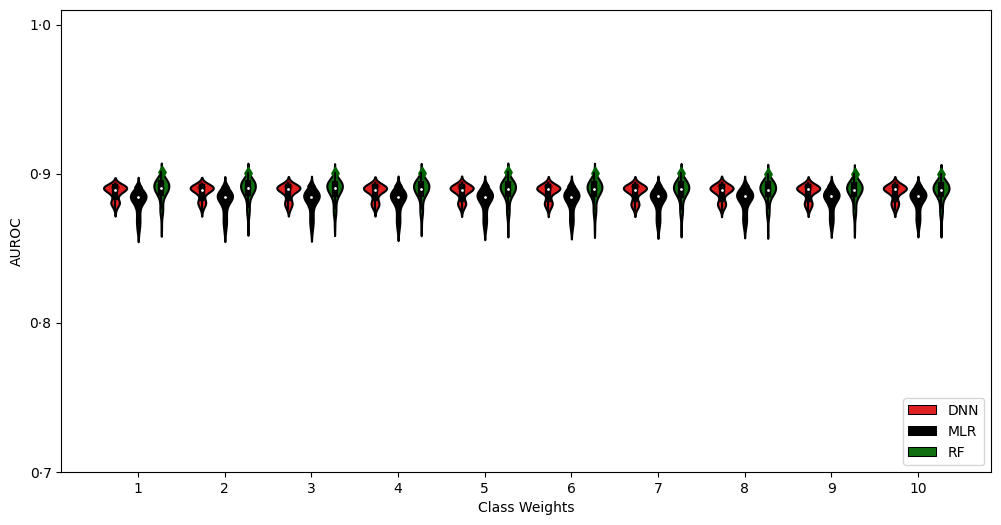

In [185]:
Violin_Plot(combined_IV_AUC_DNN, combined_IV_AUC_MLR, combined_IV_AUC_RF, True)

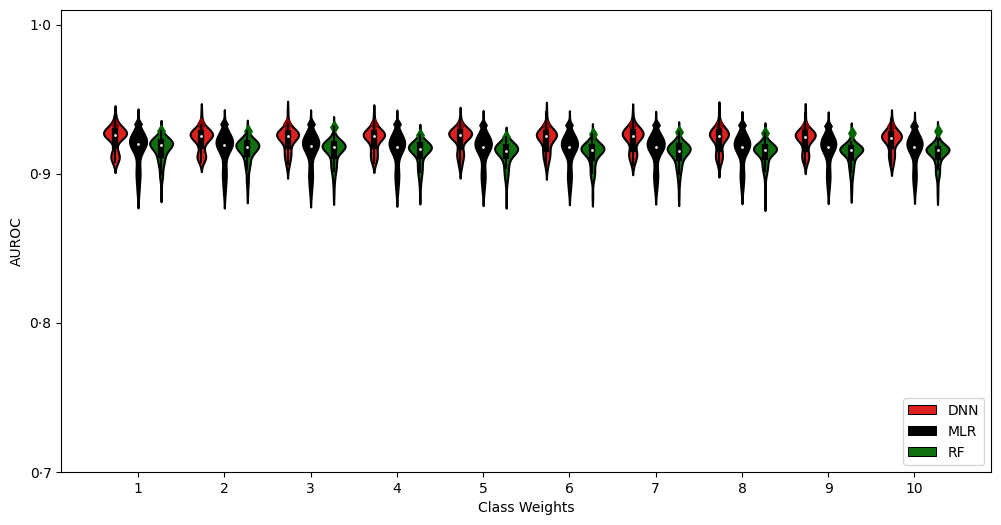

In [186]:
Violin_Plot(combined_EV_AUC_DNN, combined_EV_AUC_MLR, combined_EV_AUC_RF, True)

In [62]:
# Call the Violin_Plot function with the combined dataframes for each model
# model_list = ['MLR', 'DNN', 'RF']
# weights = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# combined_IV_AUC = [combined_IV_AUC_MLR, combined_IV_AUC_DNN, combined_IV_AUC_RF]
# combined_EV_AUC = [combined_EV_AUC_MLR, combined_EV_AUC_DNN, combined_EV_AUC_RF]

# for model_IV, model_EV in zip(combined_IV_AUC, combined_EV_AUC):
#     IV_Dataframes = [model_IV.iloc[:, i:i+1] for i in range(len(weights))]
#     EV_Dataframes = [model_EV.iloc[:, i:i+1] for i in range(len(weights))]
#     Violin_Plot(IV_Dataframes, EV_Dataframes, weights)